In [1]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

In [2]:
# Delhi Climate Data
climate_train = pd.read_csv("C:/Users/tolga/Desktop/data/climate_data/DailyDelhiClimateTrain.csv")
climate_test = pd.read_csv("C:/Users/tolga/Desktop/data/climate_data/DailyDelhiClimateTest.csv")

# Head
climate_train.head(10)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000
6,2013-01-07,7.000000,78.600000,6.300000,1020.000000
7,2013-01-08,8.857143,63.714286,7.142857,1018.714286
8,2013-01-09,14.000000,51.250000,12.500000,1017.000000
9,2013-01-10,11.000000,62.000000,7.400000,1015.666667


<AxesSubplot:title={'center':'Delhi Daily Climate Change'}>

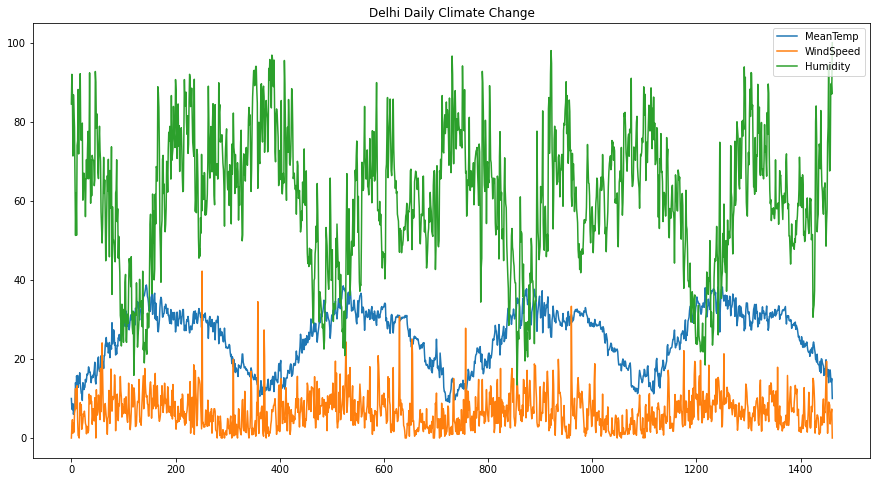

In [3]:
plt.figure(figsize=(15,8))
climate_train.meantemp.plot(label = "MeanTemp",legend = True,title = "Delhi Daily Climate Change")
climate_train.wind_speed.plot(label = "WindSpeed",legend = True)
climate_train.humidity.plot(label = "Humidity",legend = True)

<AxesSubplot:xlabel='date'>

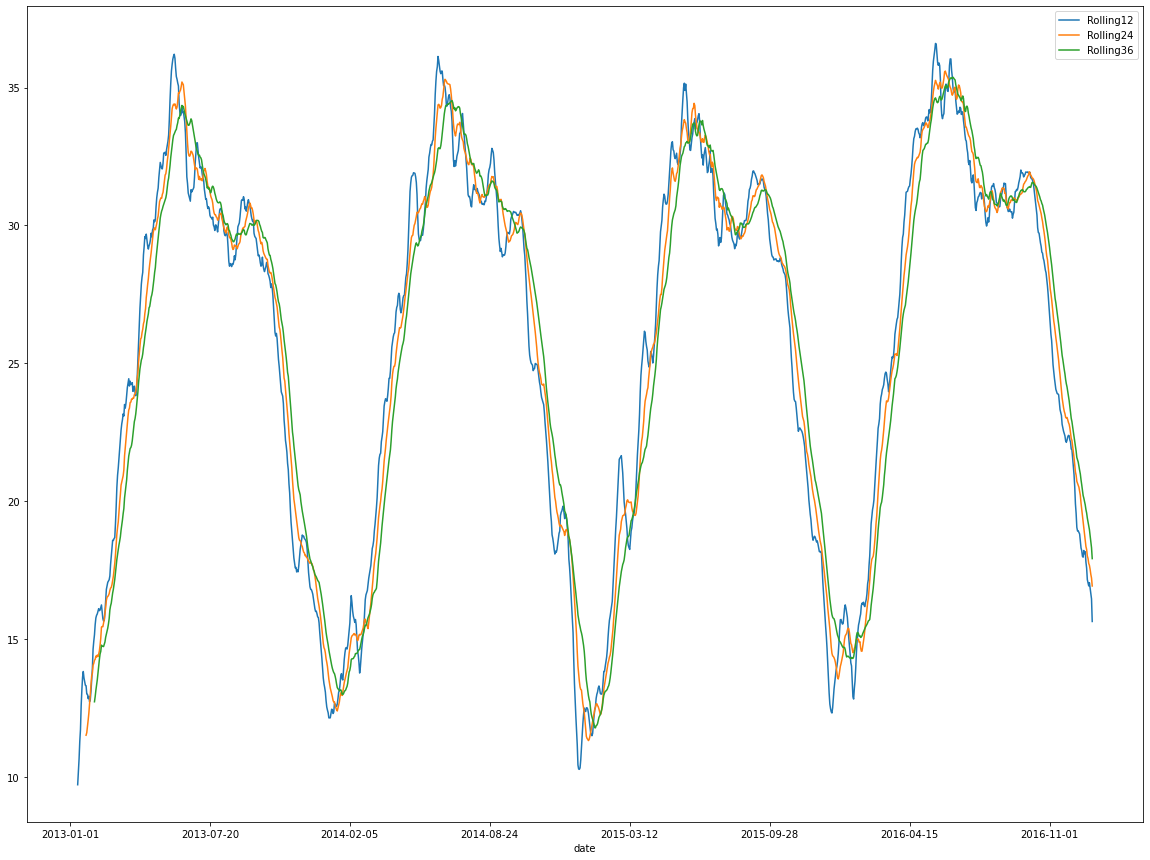

In [4]:
# Plot with rolling window
plt.figure(figsize=(20,15))
climate_train.set_index("date").meantemp.rolling(window=12).mean().plot(label = "Rolling12",legend = True)
climate_train.set_index("date").meantemp.rolling(window=24).mean().plot(label = "Rolling24",legend = True)
climate_train.set_index("date").meantemp.rolling(window=36).mean().plot(label = "Rolling36",legend = True)

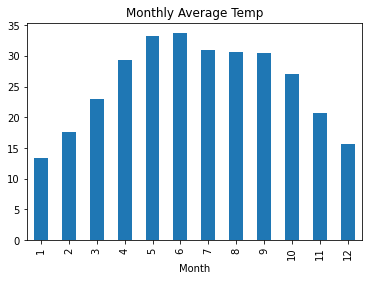

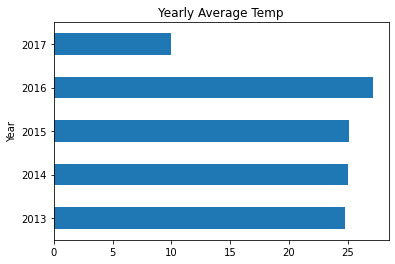

In [5]:
climate_train["date"] = pd.to_datetime(climate_train["date"])
climate_test["date"] = pd.to_datetime(climate_test["date"])

climate_train["Month"] = climate_train["date"].dt.month
climate_train["Year"] = climate_train["date"].dt.year

# Groupby 
grouped_monthly = climate_train.groupby(["Month"]).agg("mean")
grouped_yearly = climate_train.groupby(["Year"]).agg("mean")
#grouped.meantemp.plot(kind = "barh",title = "Monthly Average Temp",axis = )


grouped_monthly.meantemp.plot(kind = "bar",title = "Monthly Average Temp")
plt.show()
grouped_yearly.meantemp.plot(kind = "barh",title = "Yearly Average Temp")
plt.show()

Season
Autumn    AxesSubplot(0.125,0.125;0.775x0.755)
Spring    AxesSubplot(0.125,0.125;0.775x0.755)
Summer    AxesSubplot(0.125,0.125;0.775x0.755)
Winter    AxesSubplot(0.125,0.125;0.775x0.755)
Name: meantemp, dtype: object

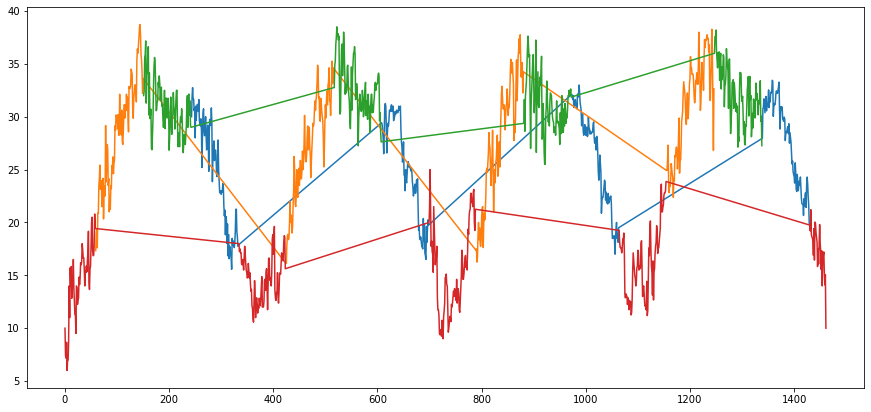

In [6]:
winter = climate_train[(climate_train["Month"] == 12) 
                       | (climate_train["Month"] == 1) | 
                       (climate_train["Month"] == 2)].index
spring = climate_train[(climate_train["Month"] == 3) 
                       | (climate_train["Month"] == 4) |
                       (climate_train["Month"] == 5)].index
summer = climate_train[(climate_train["Month"] == 6) |
                       (climate_train["Month"] == 7) |
                       (climate_train["Month"] == 8)].index
autumn = climate_train[(climate_train["Month"] == 9) |
                       (climate_train["Month"] == 10) |
                       (climate_train["Month"] == 11)].index
climate_train["Season"] = np.nan
climate_train.Season.iloc[winter] = "Winter"
climate_train.Season.iloc[spring] = "Spring"
climate_train.Season.iloc[summer] = "Summer"
climate_train.Season.iloc[autumn] = "Autumn"
plt.figure(figsize = (15,7))
climate_train.groupby("Season").meantemp.plot()

In [7]:
## Stationary
# H0 series is not stationary
sm.tsa.adfuller(climate_train.meantemp)
# P value > 0.05 H0 is no rejected

(-2.0210690559206728,
 0.27741213723016056,
 10,
 1451,
 {'1%': -3.4348647527922824,
  '5%': -2.863533960720434,
  '10%': -2.567831568508802},
 5423.895746470953)

In [8]:
# first diff
sm.tsa.adfuller(climate_train.meantemp.diff().dropna()) # Now , series is stationary...


(-16.378720267074694,
 2.7648631375945265e-29,
 9,
 1451,
 {'1%': -3.4348647527922824,
  '5%': -2.863533960720434,
  '10%': -2.567831568508802},
 5423.097584257939)

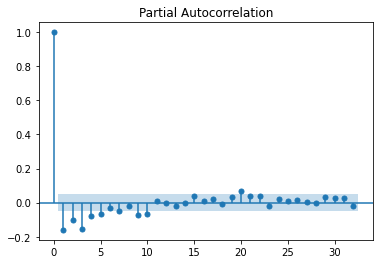

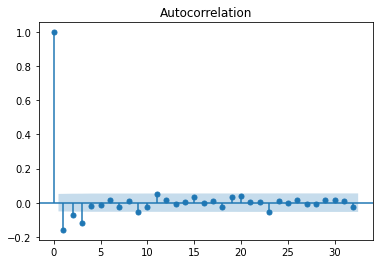

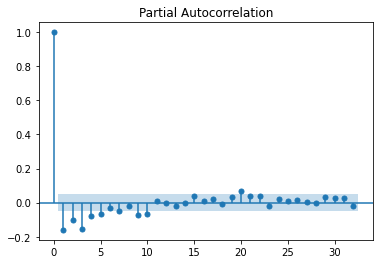

In [9]:
# acf-pacf graph
sm.graphics.tsa.plot_acf(climate_train.meantemp.diff().dropna())
sm.graphics.tsa.plot_pacf(climate_train.meantemp.diff().dropna())
# First, i will use arima  4,1,1

<AxesSubplot:xlabel='date'>

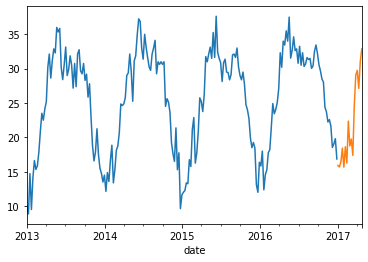

In [15]:
trainWeekly = climate_train.set_index("date").asfreq("7D")
testWeekly = climate_test.set_index("date").asfreq("7D")
trainWeekly.meantemp.plot()
testWeekly.meantemp.plot()

<AxesSubplot:title={'center':'MAE for ARIMA(5,1,1) : 4.996'}, xlabel='date'>

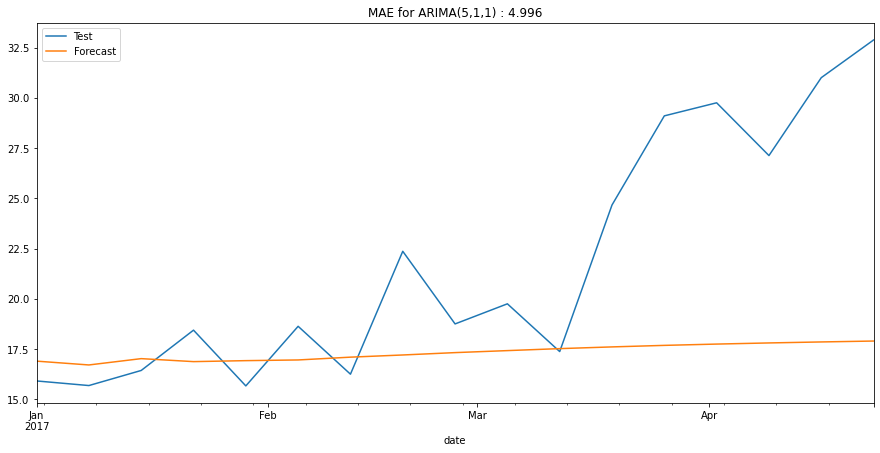

In [19]:
# ARIMA 5,1,1
arima_model = ARIMA(trainWeekly.meantemp,order=(5,1,2)).fit(disp = 0)
forecast = arima_model.forecast(len(testWeekly))[0]
forecast = pd.Series(forecast,index = testWeekly.index)
mae = mean_absolute_error(forecast,testWeekly.meantemp)
plt.figure(figsize = (15,7))
testWeekly.meantemp.plot(label = "Test",legend = True,title = "MAE for ARIMA(5,1,1) : {}".format(round(mae,3)))
forecast.plot(label = "Forecast",legend = True)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1423.195, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1254.093, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1155.973, Time=0.08 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=1112.043, Time=0.16 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=1092.450, Time=0.20 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=1073.621, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1012.907, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=1008.725, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1009.391, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=1011.237, Time=0.17 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=1001.934, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1007.782, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=1009.290, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=1011.289, Time=0.15 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=974.991, Time=0.43 sec
 ARIMA(3,0,

<AxesSubplot:title={'center':'MAE : 3.991167565493112'}, xlabel='date'>

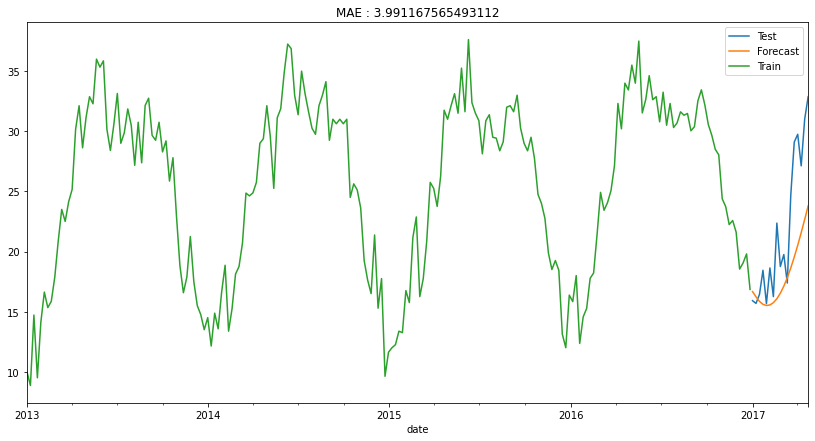

In [22]:
# Seasonal ARIMA
autoArima = auto_arima(trainWeekly.meantemp,stepwise=False,information_criterion="aic",seasonal=True,trace=True)
result = autoArima.fit(trainWeekly.meantemp)
forecast = autoArima.predict(n_periods=len(testWeekly))
testWeekly.meantemp.plot(figsize=(14, 7),label = "Test",
                         legend = True,title = "MAE : {}".format(str(mean_absolute_error(forecast,testWeekly.meantemp))))
pd.Series(forecast,index=testWeekly.index).plot(label = "Forecast",legend = True)
trainWeekly.meantemp.plot(label = "Train",legend = True)

Alpha : 0.1 - Beta : 0.1 - Gamma : 0.1 // MAE : 4.375
Alpha : 0.1 - Beta : 0.1 - Gamma : 0.25 // MAE : 4.523
Alpha : 0.1 - Beta : 0.1 - Gamma : 0.4 // MAE : 4.675
Alpha : 0.1 - Beta : 0.1 - Gamma : 0.55 // MAE : 4.886
Alpha : 0.1 - Beta : 0.1 - Gamma : 0.7 // MAE : 5.164
Alpha : 0.1 - Beta : 0.1 - Gamma : 0.85 // MAE : 5.451
Alpha : 0.1 - Beta : 0.25 - Gamma : 0.1 // MAE : 7.213
Alpha : 0.1 - Beta : 0.25 - Gamma : 0.25 // MAE : 7.578
Alpha : 0.1 - Beta : 0.25 - Gamma : 0.4 // MAE : 8.168
Alpha : 0.1 - Beta : 0.25 - Gamma : 0.55 // MAE : 8.803
Alpha : 0.1 - Beta : 0.25 - Gamma : 0.7 // MAE : 9.17
Alpha : 0.1 - Beta : 0.25 - Gamma : 0.85 // MAE : 9.094
Alpha : 0.1 - Beta : 0.4 - Gamma : 0.1 // MAE : 7.311
Alpha : 0.1 - Beta : 0.4 - Gamma : 0.25 // MAE : 7.696
Alpha : 0.1 - Beta : 0.4 - Gamma : 0.4 // MAE : 8.062
Alpha : 0.1 - Beta : 0.4 - Gamma : 0.55 // MAE : 8.22
Alpha : 0.1 - Beta : 0.4 - Gamma : 0.7 // MAE : 8.095
Alpha : 0.1 - Beta : 0.4 - Gamma : 0.85 // MAE : 7.72
Alpha : 0.1 - Be

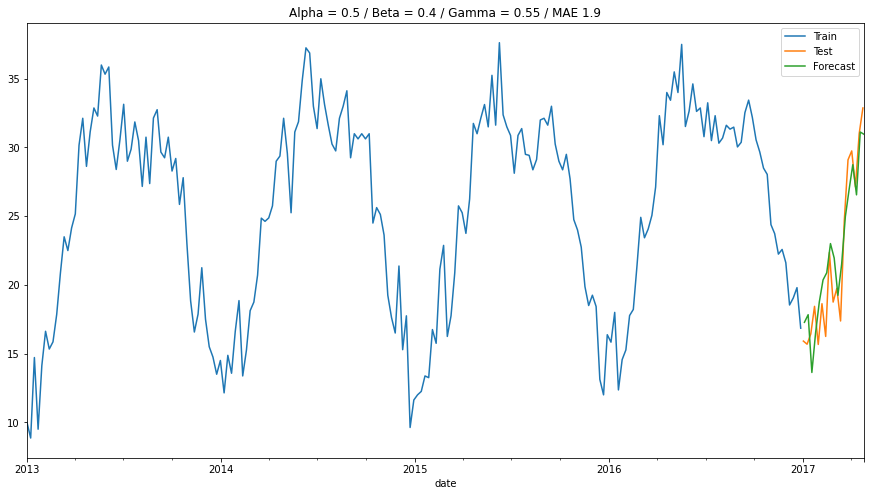

In [25]:
# HW
params_level = np.arange(0.1,1,0.05)
params_trend = np.arange(0.1,1,0.15)
params_season = np.arange(0.1,1,0.15)
def tes_optimizer(alpha,beta,gamma,train,test):
    best_level,best_trend,best_season,best_mae = None,None,None,np.float16("inf")
    for i in alpha:
        for j in beta:
            for h in gamma:
                des = ExponentialSmoothing(train,trend="add",seasonal="add",seasonal_periods=52)
                model = des.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=h)
                forecast = model.forecast(len(test))
                mae = mean_absolute_error(test,forecast)
                print("Alpha : {} - Beta : {} - Gamma : {} // MAE : {}".format(round(i,2),round(j,2),round(h,2),round(mae,3)))
                if best_mae>mae:
                    best_mae = mae
                    best_level,best_trend,best_season = model.params.get("smoothing_level"),model.params.get("smoothing_trend"),model.params.get("smoothing_seasonal")
    print("best smoothing level = {}".format(best_level),"best smoothing trend = {}".format(best_trend),"best smoothing season = {}".format(best_season),"best MAE = {}".format(best_mae))
    # final model
    DES = ExponentialSmoothing(train,trend = "add",seasonal="add",seasonal_periods=52)
    model = DES.fit(smoothing_level=best_level,smoothing_trend=best_trend,smoothing_seasonal=best_season)
    forecast = model.forecast(len(test))
    plt.figure(figsize=(15,8))
    train.plot(legend = True,label = "Train",title = "Alpha = {} / Beta = {} / Gamma = {} / MAE {}".format(round(best_level,2),round(best_trend,2),round(best_season,2),round(best_mae,2)))
    test.plot(legend = True,label = "Test")
    forecast.plot(legend = True,label = "Forecast")
    
tes_optimizer(alpha = params_level,beta=params_trend,gamma=params_season,train = trainWeekly.meantemp,test = testWeekly.meantemp)